In [1]:
#import libraries
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

from typing import Tuple, Sequence, List, Optional

from tqdm import tqdm

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
import logging

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,              # change to DEBUG for more details
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)

In [4]:
transforms = T.Compose([
                        T.ToTensor(),
                        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                      ]
                      )
trainset = torchvision.datasets.CIFAR10(root='./root', train=True, download=True, transform=transforms)
testset = torchvision.datasets.CIFAR10(root='./root', train=False, download=True, transform=transforms)


In [5]:
# Load the datsets into DataLoader
batch_size = 1024
train_loader = DataLoader(trainset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=max(2,os.cpu_count()//2),
                          pin_memory=(device.type=='cuda'),persistent_workers=True,
                          prefetch_factor=2
                          )
test_loader = DataLoader(testset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=max(2,os.cpu_count()//2),
                          pin_memory=(device.type=='cuda'),persistent_workers=True,
                          prefetch_factor=2
                          )

# Create the CNN AutoEncoder model

In [6]:
# create a class for the model
def makeTheNet():

  class CNNAEnet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.LazyConv2d(out_channels=16,kernel_size=4,padding=1, stride=2),
          nn.ReLU(),
          nn.LazyConv2d(out_channels=32,kernel_size=4,padding=1, stride=2),
          nn.ReLU(),
          )

      # Latent layer
      self.latent = nn.Sequential(
          nn.LazyConv2d(out_channels=64, kernel_size=4, padding=1, stride=2),
          nn.ReLU()
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.LazyConvTranspose2d(out_channels=32,kernel_size=4,padding=1, stride=2),
          nn.ReLU(),
          nn.LazyConvTranspose2d(out_channels=16,kernel_size=4,padding=1, stride=2),
          nn.ReLU(),
          nn.LazyConvTranspose2d(out_channels=3,kernel_size=4,padding=1, stride=2),
          nn.Sigmoid()
          )

    def forward(self,x):
      x = self.enc(x)
      x = self.latent(x)
      x = self.dec(x)
      return x

  # create the model instance
  net = CNNAEnet()

  # loss function
  lossfun = nn.MSELoss()

  return net,lossfun

In [7]:
net, lossfun = makeTheNet()
net.to(device)
X, _ = next(iter(train_loader))

X = X.to(device)

with torch.no_grad():
  _ = net(X)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001) #With Lazy layers optimizer needs to be set after instantiating the model

net.train()
yHat = net(X)
loss = lossfun(yHat,X)
print(loss)

tensor(0.5644, device='cuda:0', grad_fn=<MseLossBackward0>)


# Create a function to train the model

In [8]:
def function2trainTheModel(numepochs: int):
    # ---------- Device selection (don’t rely on outer globals) ----------
    # if device is None:
    #     if torch.cuda.is_available():
    #         device = torch.device("cuda")
    #     elif torch.backends.mps.is_available():
    #         device = torch.device("mps")
    #     else:
    #         device = torch.device("cpu")
    print("Using device:", device)

    net, lossfun = makeTheNet() # Corrected to unpack net and lossfun
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    net.to(device)
    lossfun = lossfun.to(device)

    # ---------- AMP (new API); enable only on CUDA ----------
    use_cuda = (device.type == "cuda")
    scaler = torch.amp.GradScaler(enabled=use_cuda)
    autocast_ctx = torch.autocast(device_type="cuda",dtype=torch.float16, enabled=use_cuda)

    # ---------- Metrics (avoid per-batch .item() → sync once/epoch) ----------
    trainLoss = torch.zeros(numepochs)
    testLoss  = torch.zeros(numepochs)


    net.train()
    # ---------- Epoch loop ----------
    for epochi in range(numepochs):
    # for epochi in range(numepochs):
        # ---------- Batch loop ----------
        batch_loss_sum = torch.zeros((), device=device)
        n_seen = 0 # Initialize n_seen

        for X, y in train_loader:
        # for X, y in train_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with autocast_ctx:
                yHat = net(X)
                loss = lossfun(yHat, X)

            if use_cuda:
                scaler.scale(loss).backward()
                scaler.step(optimizer) # Corrected to use optimizer
                scaler.update()
            else:
                loss.backward()
                optimizer.step() # Corrected to use optimizer

            # accumulate on device (no CPU sync)
            with torch.no_grad():
                batch_loss_sum += loss.detach() * X.size(0) # Corrected to use X.size(0)
                n_seen += X.size(0) # Corrected to use X.size(0)


        # end train epoch: sync once
        trainLoss[epochi] = (batch_loss_sum / max(n_seen, 1)).detach().cpu()

        # --------Evaluation on full test loader (not a single batch) ----------
        net.eval()
        test_loss_sum = torch.zeros((), device=device)
        test_err_count = torch.zeros((), device=device, dtype=torch.long)
        test_seen = 0

        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yHat = net(X)
                test_loss_sum += lossfun(yHat, X) * X.size(0)
                test_seen += X.size(0)


        testLoss[epochi] = (test_loss_sum / max(test_seen, 1)).detach().cpu()


    # End epoch
    return trainLoss, testLoss, net

# Run the model

In [9]:
train_losses, test_losses, net = function2trainTheModel(20)

print("Train Losses:", train_losses[-1])
print("Test Losses:", test_losses[-1])

Using device: cuda:0
Train Losses: tensor(0.1528)
Test Losses: tensor(0.1495)


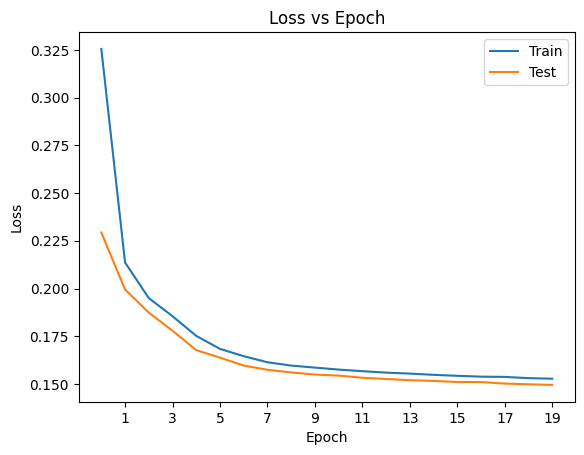

In [10]:
plt.plot(range(20),train_losses,label='Train')
plt.plot(range(20),test_losses,label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.xticks(range(1,20,2))
plt.legend()
plt.show();

# Denormalize data for plotting

In [17]:
mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)

def denormalize(x):
  x = x * std + mean
  x = x.clamp(0,1)

  return x



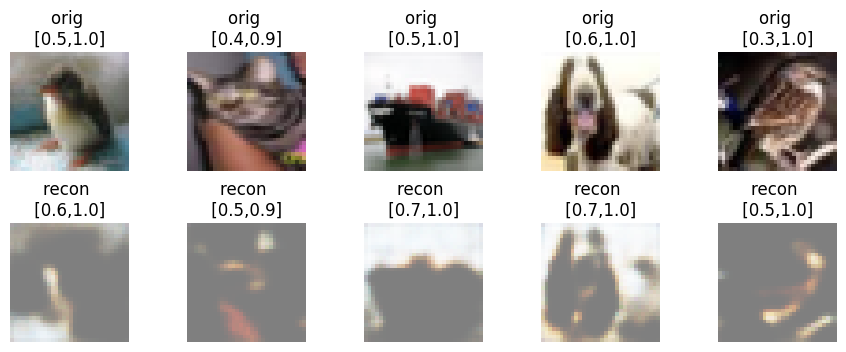

In [18]:
n=5

net.eval()
with torch.no_grad():
      X, _ = next(iter(test_loader))
      X = X.to(device)
      yHat = net(X)

X = X.cpu()
yHat = yHat.cpu()

batch_size = X.shape[0]
assert n <= batch_size, f"n ({n}) must be less than or equal to batch_size ({batch_size})"

X = denormalize(X)
yHat = denormalize(yHat)

# random indices
randidx = np.random.choice(X.shape[0], n, replace=False)

# prepare a small batch for plotting
Xn    = X[randidx]
yHn   = yHat[randidx]

# layout: two rows (orig on top, recon on bottom)
fig, axs = plt.subplots(2, n, figsize=(1.8*n, 3.6))
for i in range(n):
      # original
      axs[0, i].imshow(np.transpose(Xn[i].numpy(), (1, 2, 0)))
      axs[0, i].axis("off")
      axs[0, i].set_title(f"orig \n [{Xn[i].mean():.1f},{Xn[i].max():.1f}] ")

      # reconstruction
      axs[1, i].imshow(np.transpose(yHn[i].numpy(), (1, 2, 0)))
      axs[1, i].axis("off")
      axs[1, i].set_title(f"recon \n [{yHn[i].mean():.1f},{yHn[i].max():.1f}] ")

plt.tight_layout()
plt.show();